<a href="https://colab.research.google.com/github/ondraperny/BI-BPR-2019/blob/master/Data_preprocessor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data preprocessor
Modul for preprocessing data. To simplify different types of preprocessed data.

Function:

**Copy whole content(subdirs recursively) to new path while applying filters co copied pictures.**

In [3]:
import sys
# check if code run on colab or local
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  # Mount google drive
  from google.colab import drive
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**PATH_ORIGIN**      is path to directory with input data

**PATH_DESTINATION** is path to directory where copy of transformed data will be saved(file structure of transformed dir will remain same)

If we dont want to create copy, just transform data, then set PATH_DESTINATION same as PATH_ORIGIN.

In [0]:
PATH_ORIGIN= "/content/drive/My Drive/SKOLA/Bachelor_work/XR_HUMERUS/"
PATH_DESTINATION = "/content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/XR_HUMERUS/"
PATH_DESTINATION_ = "/content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/XR_HUMERUS/"
PATH_DESTINATION = "/content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/XR_HUMERUS/"

PATH_ORIGIN_LOCAL = "G:\\My Drive\\SKOLA\\Bachelor_work\\XR_HUMERUS\\"
PATH_DESTINATION_LOCAL = "G:\\My Drive\\SKOLA\\Bachelor_work\\preprocessed_data\\XR_HUMERUS\\"

### Data transformation class
currently only class with all required methods

In [0]:
from PIL import Image
from pathlib import Path
import numpy as np
import os
import IPython.display

class DataTransformation():
  """Encapsulate functions that are neccesary for processing images
  and handling file structure
  
  Attributes
  ----------
  PATH_ORIGIN : str
    valid path to dir with input data
  PATH_DESTINATION : str
    path to dir with output data (path does not have to exist yet)

  Methods
  -------
  correct_dir_path(path)
    If path string does not end with '\', it adds it to the path
  change_path(old_path, destination_path, file_path)
    Change path of file from old dir to a new one
  generate_subdirs(in_path)
  generate_image_paths(dir_path)
  open_image(image_path, return_in_PIL_format = False)
  save_image(image_numpy_array, path_to_dir, image_name)
  show_images(*images)
  copy_imgs_apply_filters(self, max_images_per_dir, *filters)
    Loads images from from PATH_ORIGIN, pply every filter function to an images
    and save in same file structure
  """

  def __init__(self, PATH_ORIGIN, PATH_DESTINATION):
    if not IN_COLAB:
      PATH_ORIGIN =      "G:"+PATH_ORIGIN[14:].replace('/', '\\\\')
      PATH_DESTINATION = "G:"+PATH_DESTINATION[14:].replace('/', '\\\\')
    self.PATH_ORIGIN = PATH_ORIGIN
    self.PATH_DESTINATION = PATH_DESTINATION

  def correct_dir_path(self, path):
    """check if string is correct path to directory - ends with slash
    if it doesn't, it adds it
    @return correct path"""
    if path[-1] != '/' and IN_COLAB:
      path = path + '/'
    elif path[-1] != '\\' and not IN_COLAB:
      path = path + '\\'
    return path

  def change_path(self, old_path, destination_path, file_path):
    """take file_path, trim old_path from it and add destination_path instead"""
    old_path = self.correct_dir_path(old_path)
    old_path_len = len(old_path)
    # cut off prefix(old_path) from file_path
    dir_path_from_current = str(file_path)[old_path_len:]
    destination_path = self.correct_dir_path(destination_path)
    return destination_path + dir_path_from_current

  @staticmethod
  def generate_subdirs(dir_path):
    """Return generator to all subdirectories of in_path"""
    for path in Path(dir_path).glob("**"):
      yield path

  @staticmethod
  def generate_image_paths(dir_path):
    """Generator with path to every png image in specified dir"""
    for image in Path(dir_path).glob("*.png"):
      yield image

  @staticmethod
  def open_image(image_path, return_in_PIL_format = False):
    """Open image, based on parameter return image type"""
    try:
      image_PIL = Image.open(image_path).convert('L')
      if return_in_PIL_format:
        return image_PIL
      else:
        return np.array(image_PIL)
    except:
      print("Can't open image \"" + str(image_path) + "\"")

  def save_image(self, image_numpy_array, path_to_dir, image_name):
    """Save image to specified path, with specified name"""
    path_to_dir = self.correct_dir_path(path_to_dir)
    image = Image.fromarray(image_numpy_array)
    image.save(path_to_dir+image_name+".png")
    print("Image " + image_name + ".png saved in " + path_to_dir)

  @staticmethod
  def show_images(*images):
    for img in images:
      IPython.display.display(Image.fromarray(img))

  def copy_imgs_apply_filters(self, max_images_per_dir, *filters):
    """Create directories in new path and copy all images in those directories, as well
    apply filter on image
    
    Parameters
    ----------
    max_images_per_dir : int
      maximum amount of processed images per directory 
    """

    for directory in self.generate_subdirs(self.PATH_ORIGIN):
      # Create target directory & all intermediate directories if don't exists
      new_path = self.change_path(self.PATH_ORIGIN, self.PATH_DESTINATION, directory)
      # print(new_path)
      try:
        os.makedirs(new_path)    
        print("Directory Created: " , new_path)
      except FileExistsError:
        print("Directory Already exists: " , new_path)
      
      cnt = 0
      for image_path in self.generate_image_paths(directory):
        image = self.open_image(image_path)
        for filter in filters:
          image = filter(image)         
        self.save_image((image), new_path, Path(image_path).stem)

        if max_images_per_dir == 0:
          continue
        elif cnt >= max_images_per_dir:
          break
        else:
          cnt = cnt + 1

### Specific filters that can be used on data
Encapsulated in class ImageFilters

In [0]:
import cv2
from google.colab.patches import cv2_imshow

class ImageFilters:
  """Encapsulate all image filter functions
  
  Methods
  -------
  smoother(img)
  histogram_equalization(img)
  clahe(img)
  """

  @staticmethod
  def smoother(img):
    """smoother the image"""
    kernel = np.ones((5,5),np.float32)/25
    return cv2.filter2D(img,-1,kernel)

  @staticmethod
  def histogram_equalization(img):
    """Spread most frequent intensity values, creating better contrast image"""
    return cv2.equalizeHist(img)
  
  @staticmethod
  def clahe(img):
    """Contrast limited adaptive histogram equalization - works with adaptive
    areas with small contrast amplification"""
    clahe =  cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return clahe.apply(img)

  #https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html
  @staticmethod
  def find_region_of_interest(img):
    """TODO: perfect dilating picture and then properly cut ROI zones from
    pictures"""
    cv2_imshow(img)
    img_mask = Otsu_thresh_after_gauss(img)

    img_mask = erode(img_mask)
    img_mask = dilate(img_mask)

    h, w = img_mask.shape[0:2]
    print(h, w)
    bottom_right = img_mask[h-1, w-1]
    bottom_left = img_mask[0, w-1]
    upper_left = img_mask[0, 0]
    upper_right = img_mask[h-1, 0]
    if int(bottom_right) + int(bottom_left) + int(upper_left) + int(upper_right) > 255:
      img_mask = 255 - img_mask
    print(h-1, w-1, 0, w-1, 0, 0, h-1, 0)
    print(bottom_right, bottom_left, upper_left, upper_right)
    print(int(bottom_right) + int(bottom_left) + int(upper_left) + int(upper_right))

    # cv2_imshow(img_mask)
    # TODO remake this method, probably remove bordering and cut just from
    # original picture
    bordersize = 100

    border = cv2.copyMakeBorder(
      img_mask,
      top=bordersize,
      bottom=bordersize,
      left=bordersize,
      right=bordersize,
      borderType=cv2.BORDER_CONSTANT,
      value=[0, 0, 0]
      )
    cv2_imshow(border)
    

    img = cv2.copyMakeBorder(
      img,
      top=bordersize,
      bottom=bordersize,
      left=bordersize,
      right=bordersize,
      borderType=cv2.BORDER_DEFAULT,
      )

    contours = find_contour(border)
    # draw_min_rect_circle(img, contours)

    # for c in contours:
    #   # get the min area rect
    #   rect = cv2.minAreaRect(c)
    #   box = cv2.boxPoints(rect)
    #   # convert all coordinates floating point values to int
    #   box = np.int0(box)
    #   # draw a red 'nghien' rectangle
    #   cv2.drawContours(img, [box], 0, (0, 0, 255))
    # cv2_imshow(img)

    # contours = find_contour(img_mask)
    unified = []
    cont = np.vstack(contours)
    hull = cv2.convexHull(cont)
    unified.append(hull)

    # print(contours[0])
    # print(hull)

    rect = cv2.minAreaRect(hull)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.drawContours(img, [box], 0, (0, 0, 255))
    
    # cv2.drawContours(img,unified,-1,(0,255,0),2)
    # cv2.drawContours(thresh,unified,-1,255,-1)
    cv2_imshow(img)


    return img


# during erosion white part is reduced
# during dilation white part is increased (background is black)
def erode(img):
    kernel = np.ones((10,10),np.uint8)
    erosion = cv2.erode(img,kernel,iterations = 3)
    return erosion

def dilate(img):
    kernel = np.ones((5,5),np.uint8)
    dilation = cv2.dilate(img,kernel,iterations = 2)
    return dilation

def find_contour(ref_mask):
    contours, hierarchy = cv2.findContours(ref_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    print(f'Found {len(contours)} contours.')
    return contours

def draw_contour(image, contours):
    contour_drawn = cv2.drawContours(image.copy(), contours, -1, color=(255, 0, 0 ), thickness=10)
    trans.show_images(contour_drawn)
    
def Otsu_thresh_after_gauss(img):
    # Otsu's thresholding after Gaussian filtering
    blur = cv2.GaussianBlur(img,(5,5),0)
    _, th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return th3

Directory Already exists:  /content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/XR_HUMERUS/
Directory Already exists:  /content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/XR_HUMERUS/train
Directory Already exists:  /content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/XR_HUMERUS/train/train_negative


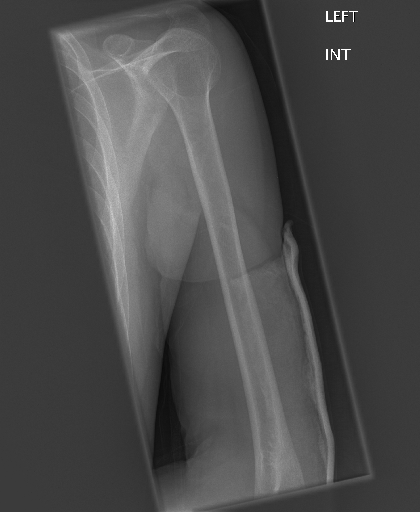

512 420
511 419 0 419 0 0 511 0
0 0 0 0
0


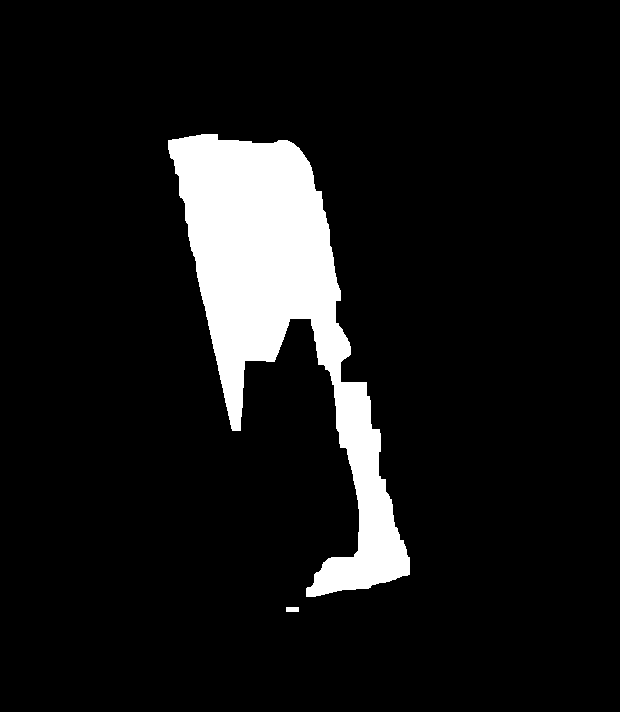

Found 2 contours.


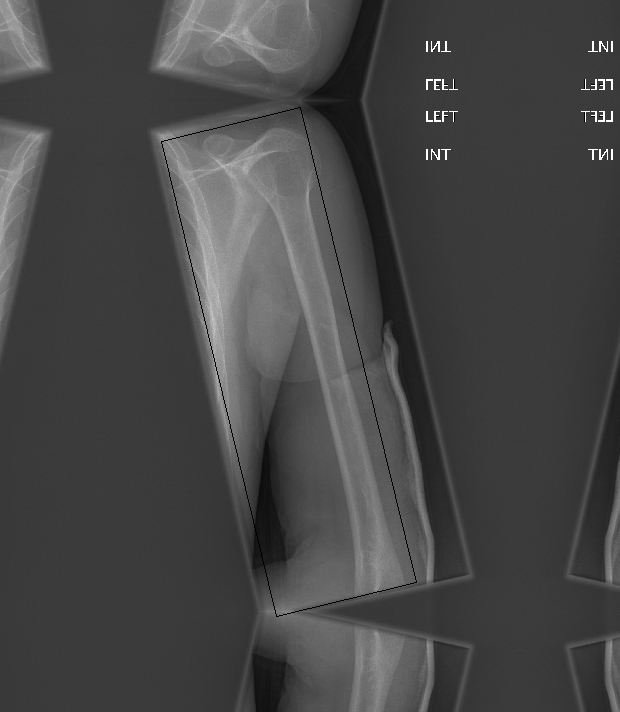

Image 214.png saved in /content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/XR_HUMERUS/train/train_negative/


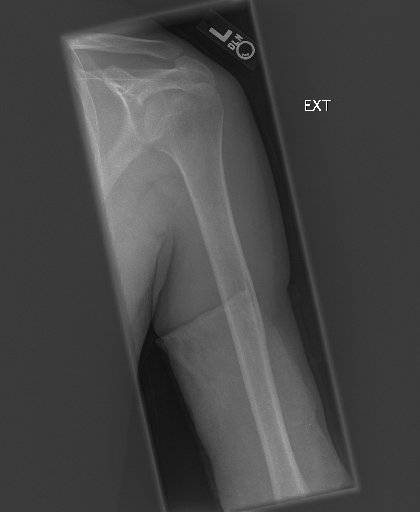

512 420
511 419 0 419 0 0 511 0
0 0 0 0
0


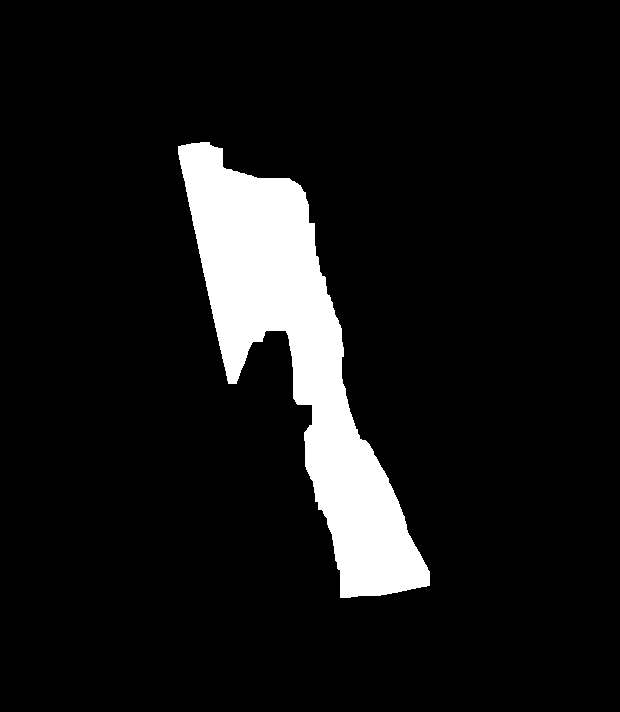

Found 1 contours.


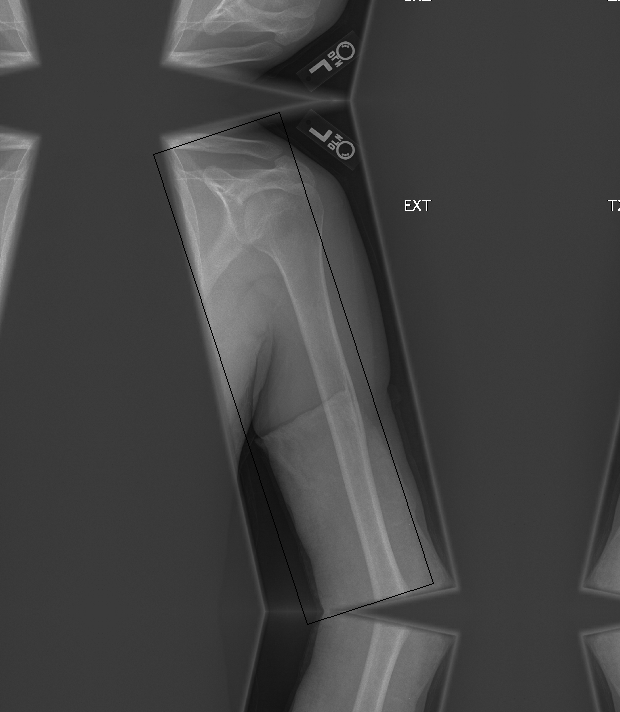

Image 215.png saved in /content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/XR_HUMERUS/train/train_negative/


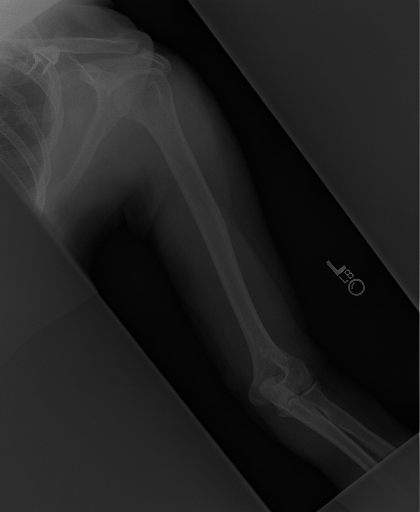

512 420
511 419 0 419 0 0 511 0
255 255 255 255
1020


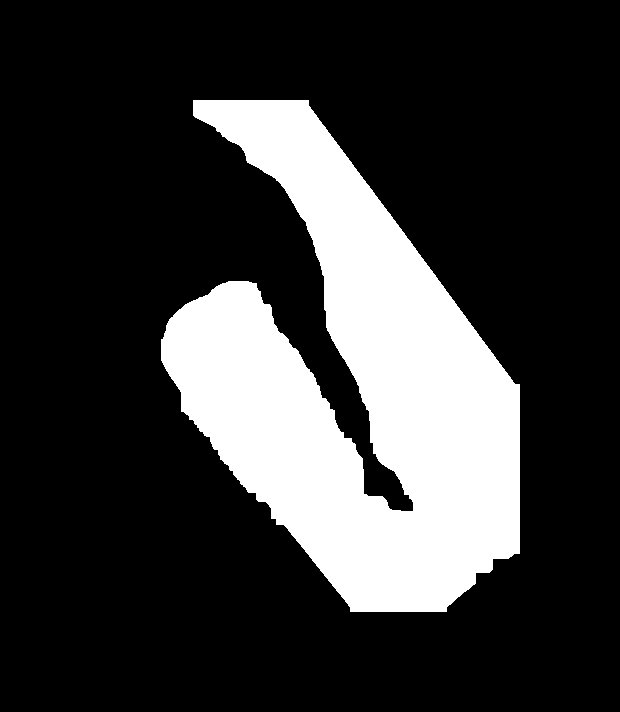

Found 1 contours.


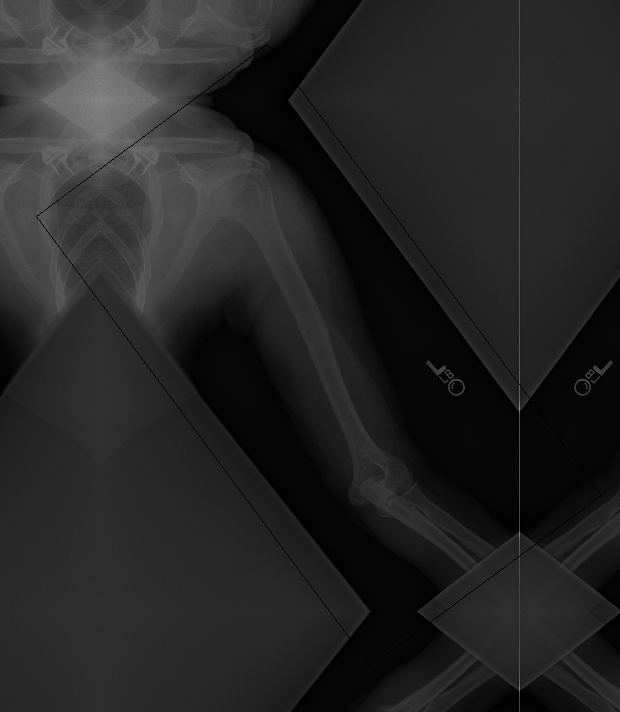

Image 216.png saved in /content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/XR_HUMERUS/train/train_negative/


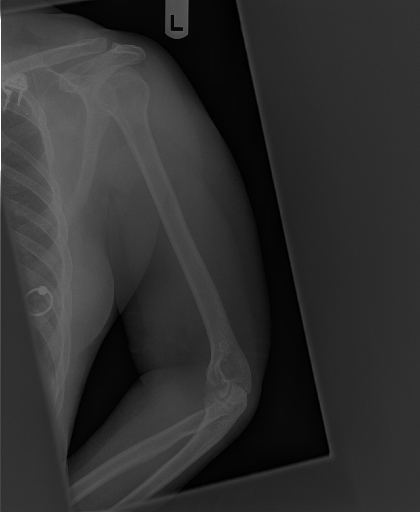

512 420
511 419 0 419 0 0 511 0
0 0 0 0
0


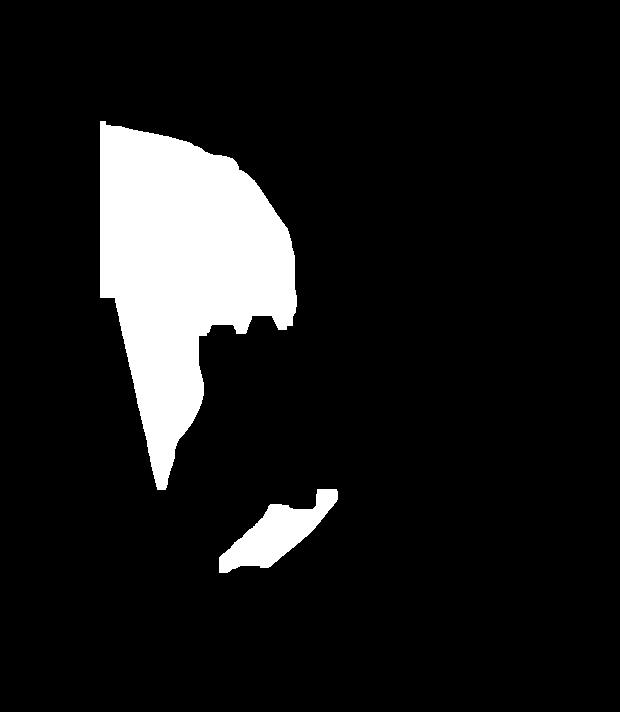

Found 2 contours.


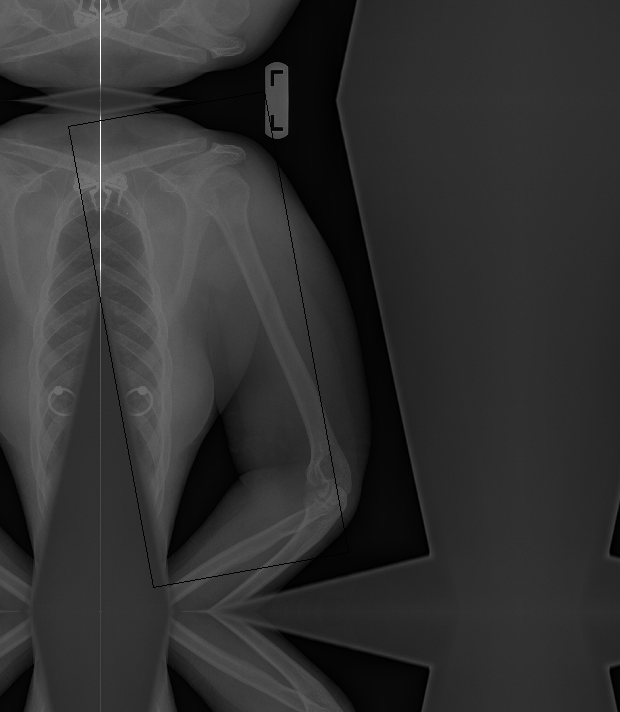

Image 217.png saved in /content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/XR_HUMERUS/train/train_negative/


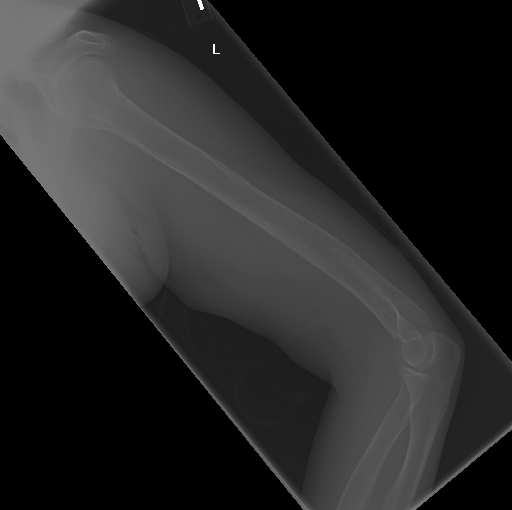

510 512
509 511 0 511 0 0 509 0
0 0 255 0
255


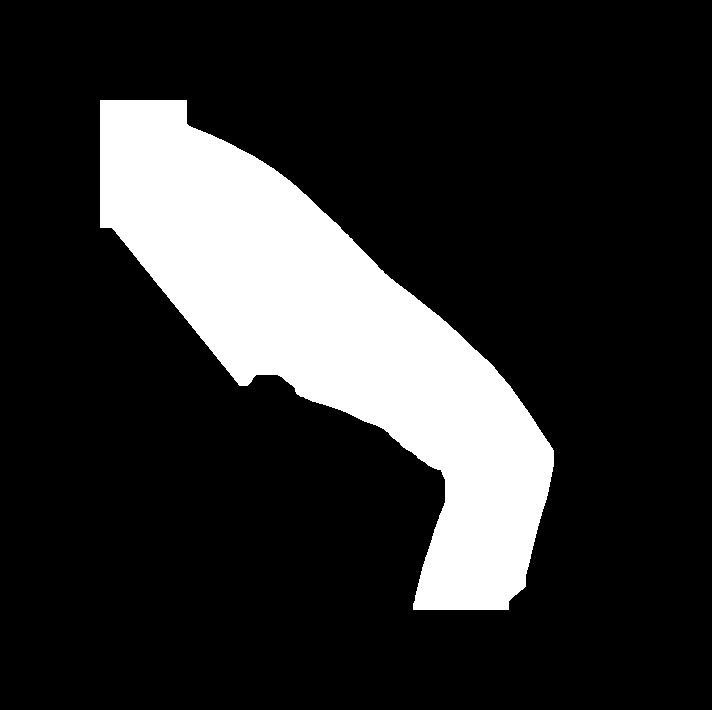

Found 1 contours.


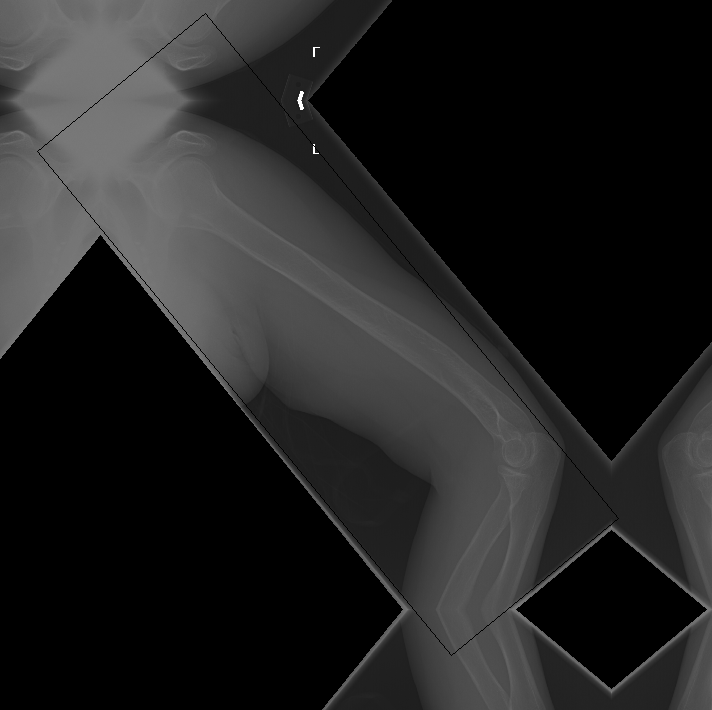

Image 218.png saved in /content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/XR_HUMERUS/train/train_negative/


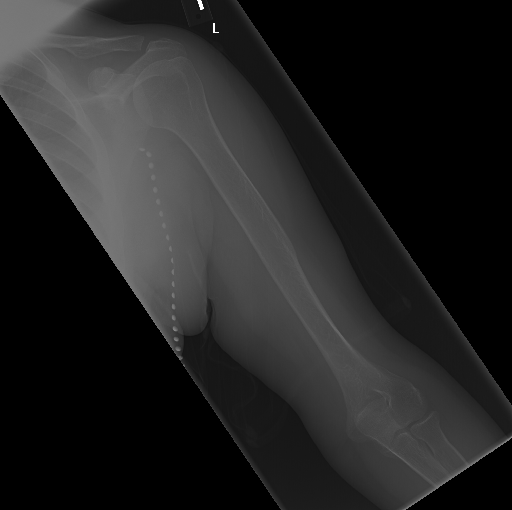

510 512
509 511 0 511 0 0 509 0
0 0 255 0
255


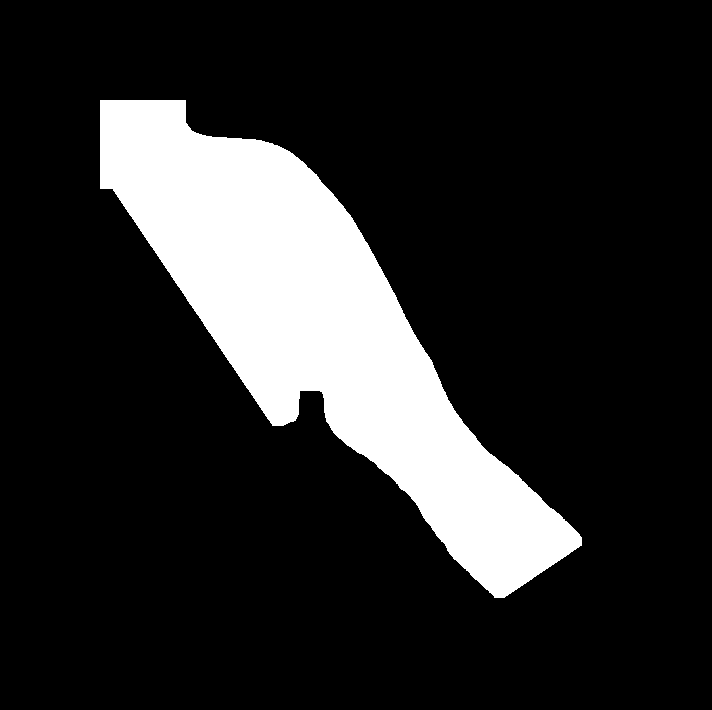

Found 1 contours.


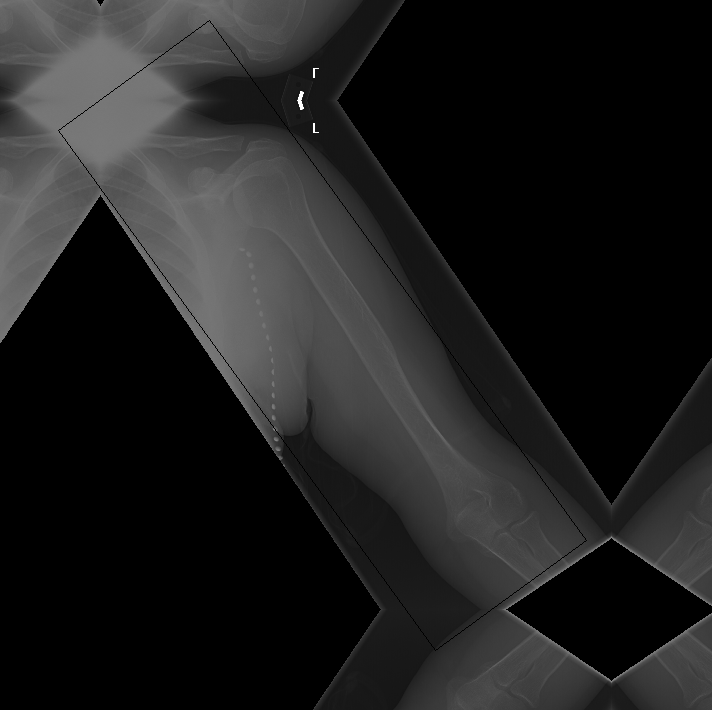

Image 219.png saved in /content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/XR_HUMERUS/train/train_negative/
Directory Already exists:  /content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/XR_HUMERUS/train/train_positive


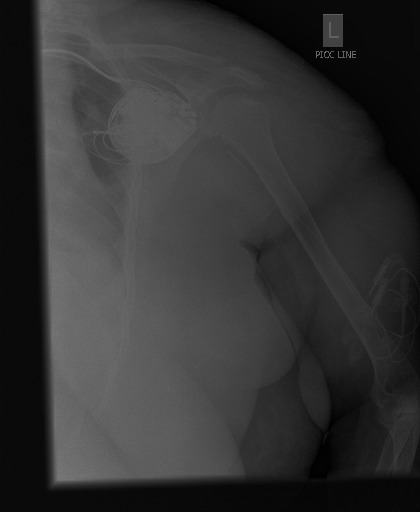

512 420
511 419 0 419 0 0 511 0
0 0 0 0
0


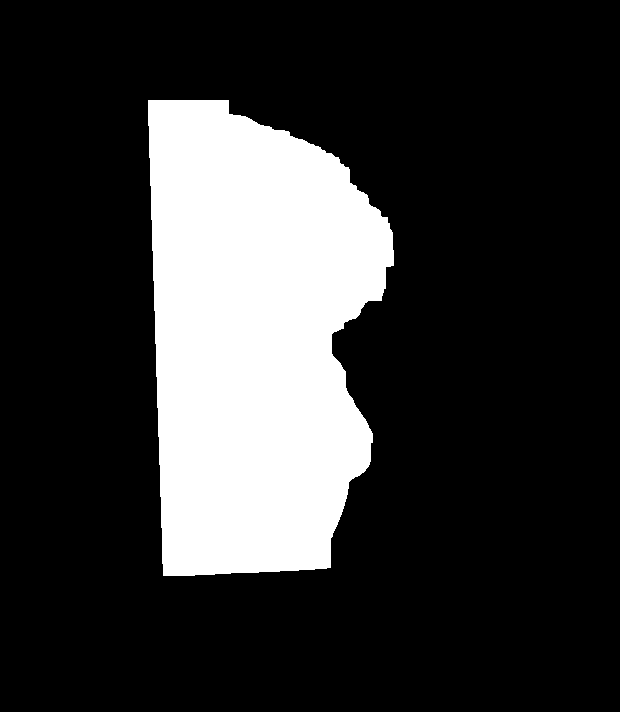

Found 1 contours.


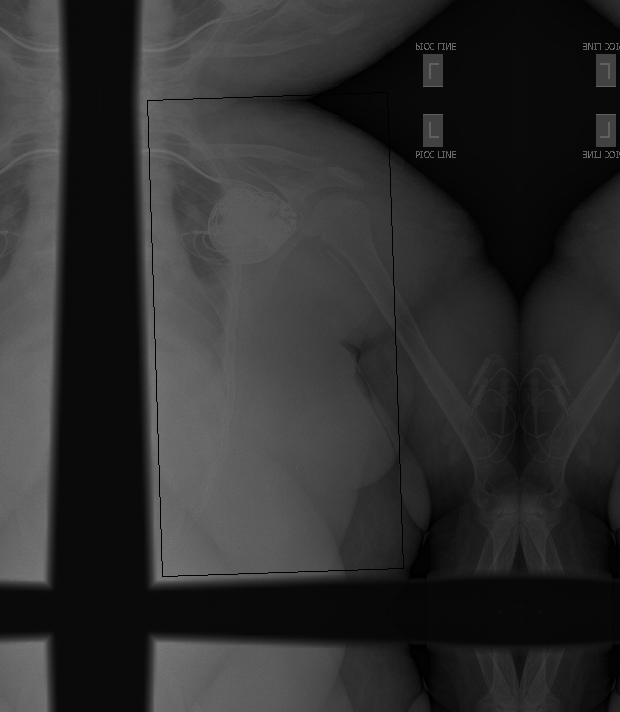

Image 139.png saved in /content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/XR_HUMERUS/train/train_positive/


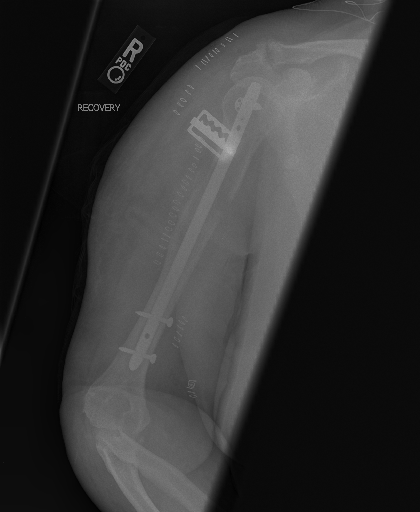

512 420
511 419 0 419 0 0 511 0
0 0 0 0
0


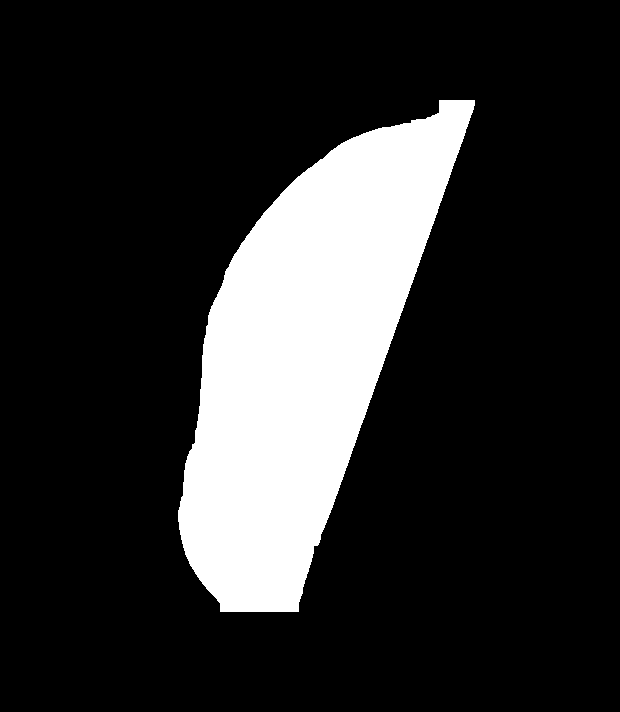

Found 1 contours.


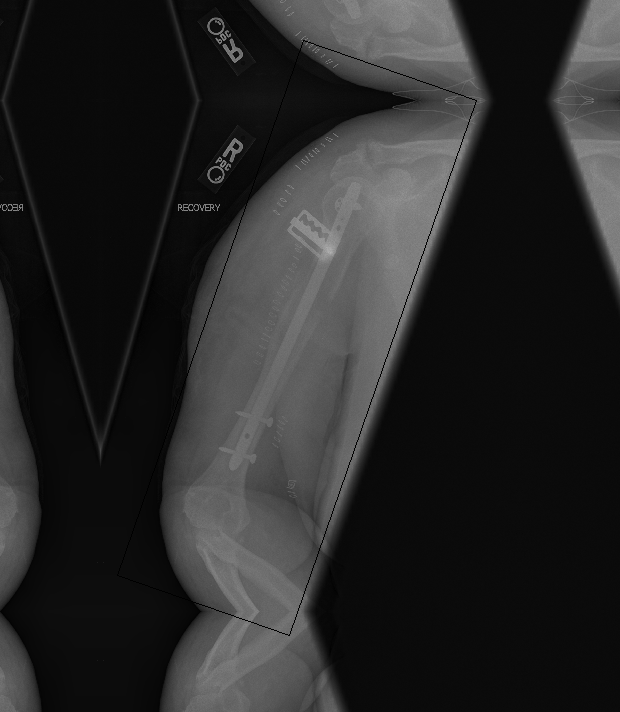

Image 140.png saved in /content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/XR_HUMERUS/train/train_positive/


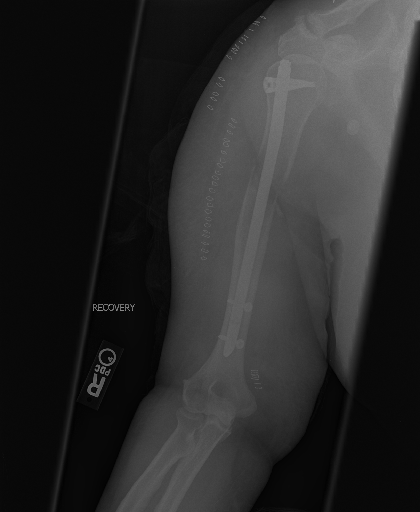

512 420
511 419 0 419 0 0 511 0
0 255 0 0
255


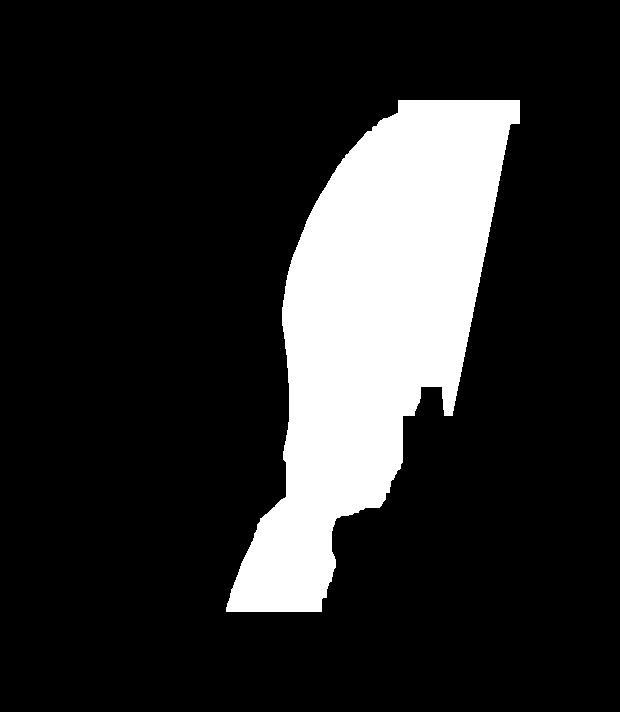

Found 1 contours.


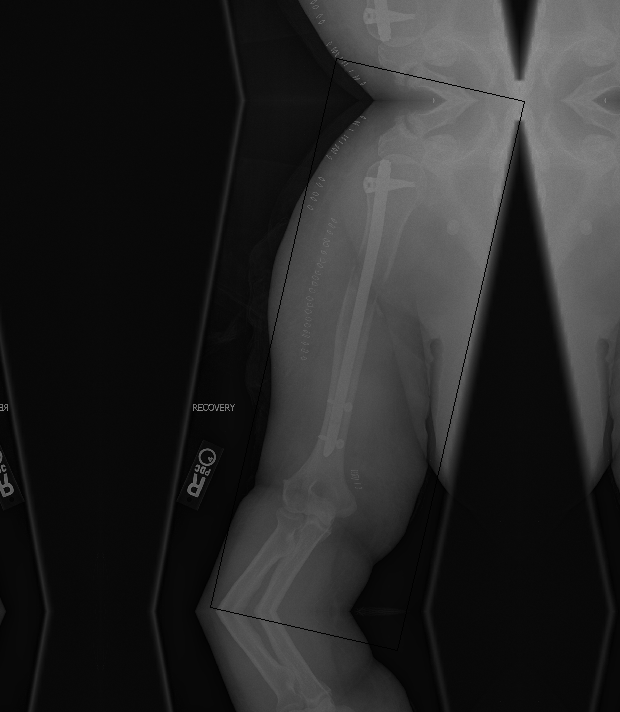

Image 141.png saved in /content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/XR_HUMERUS/train/train_positive/


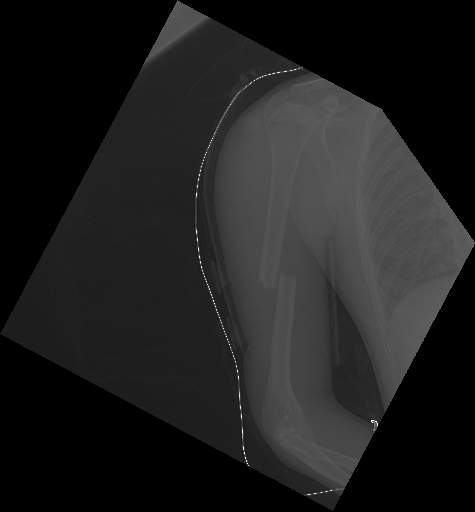

512 475
511 474 0 474 0 0 511 0
0 0 0 0
0


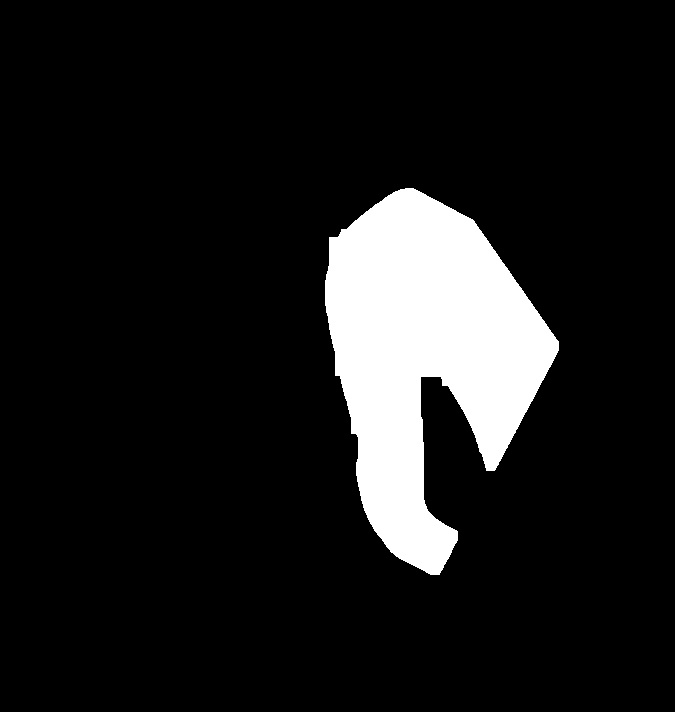

Found 1 contours.


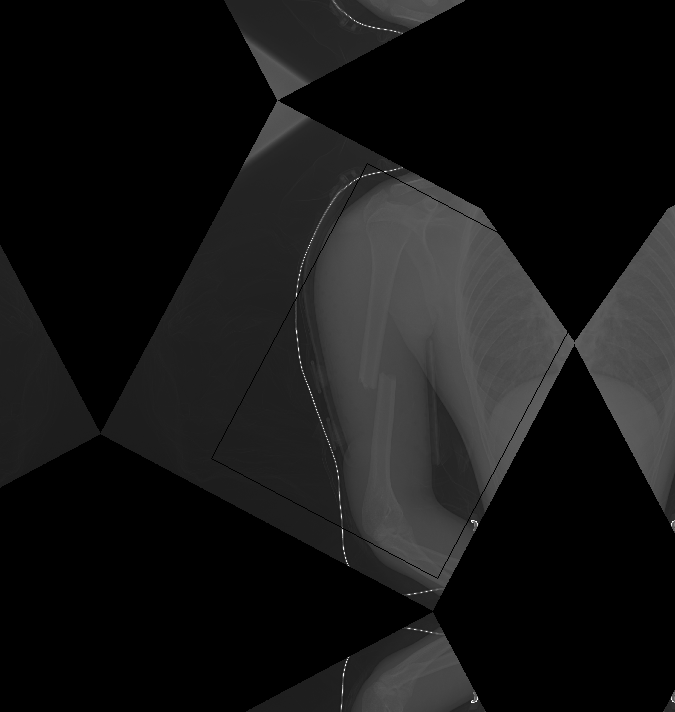

Image 142.png saved in /content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/XR_HUMERUS/train/train_positive/


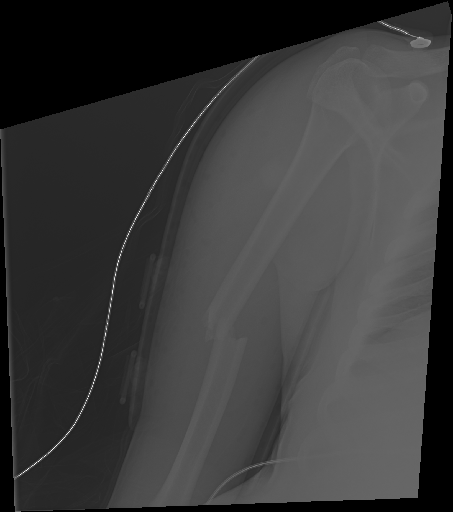

512 453
511 452 0 452 0 0 511 0
0 0 0 0
0


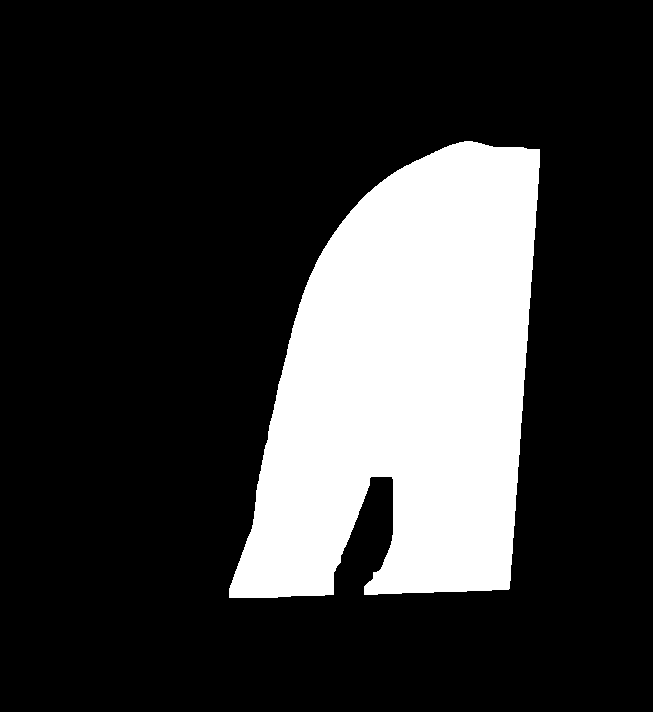

Found 1 contours.


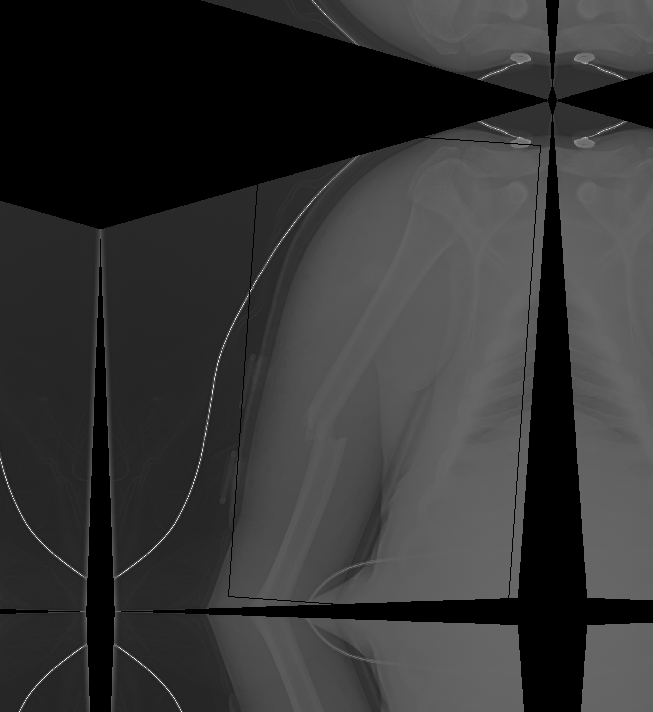

Image 143.png saved in /content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/XR_HUMERUS/train/train_positive/


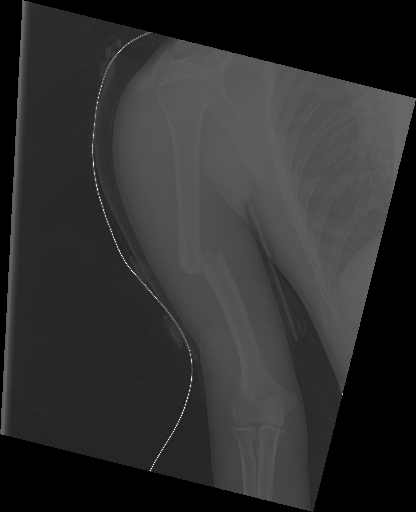

512 416
511 415 0 415 0 0 511 0
0 0 0 0
0


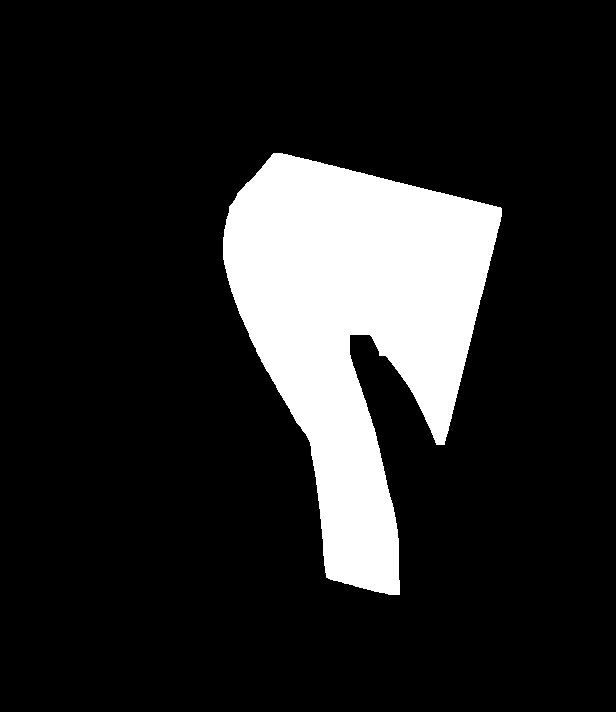

Found 1 contours.


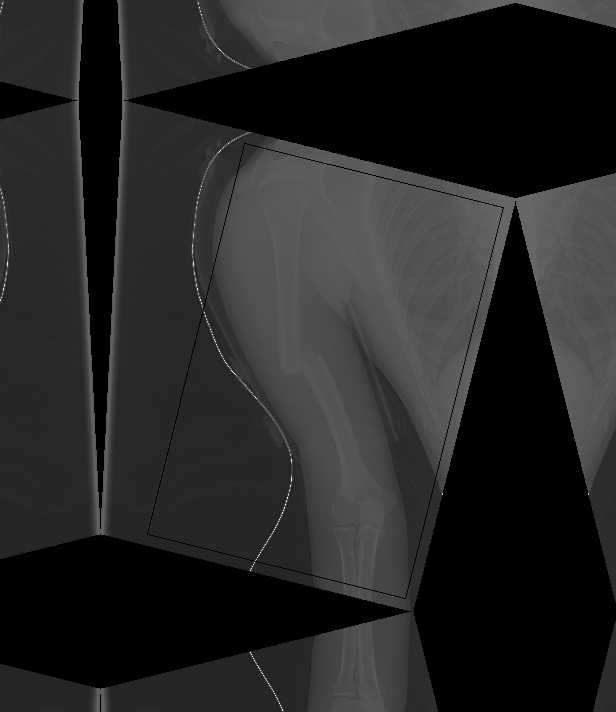

Image 144.png saved in /content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/XR_HUMERUS/train/train_positive/
Directory Already exists:  /content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/XR_HUMERUS/valid
Directory Already exists:  /content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/XR_HUMERUS/valid/valid_negative


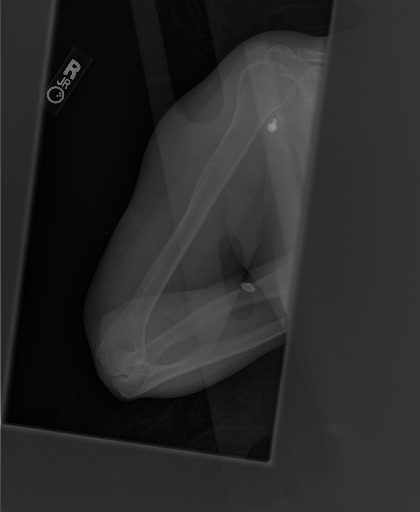

512 420
511 419 0 419 0 0 511 0
255 255 255 255
1020


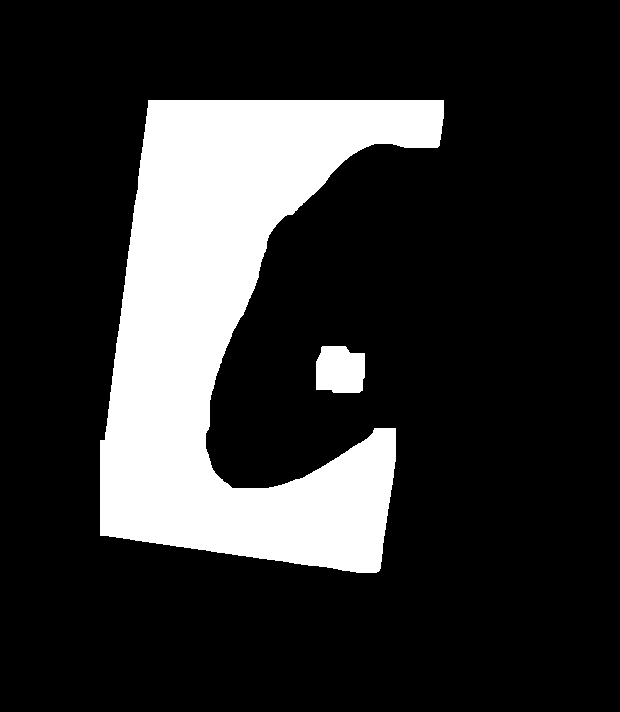

Found 2 contours.


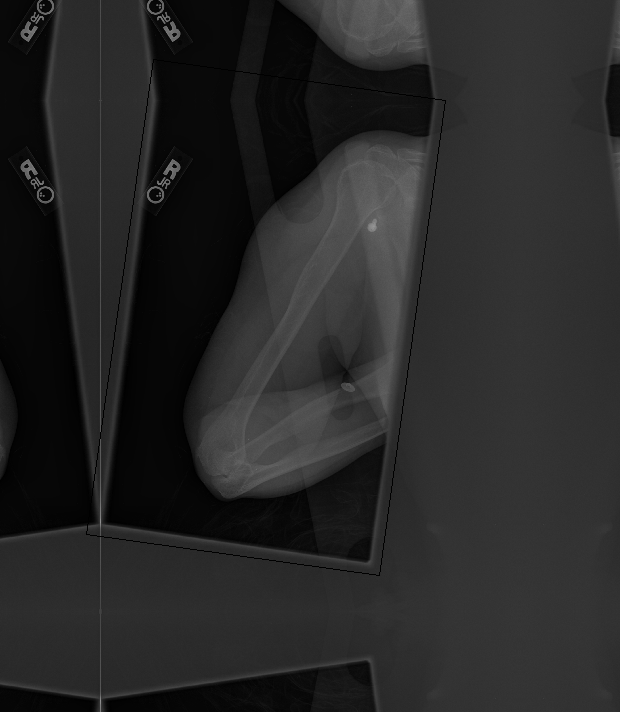

Image 0.png saved in /content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/XR_HUMERUS/valid/valid_negative/


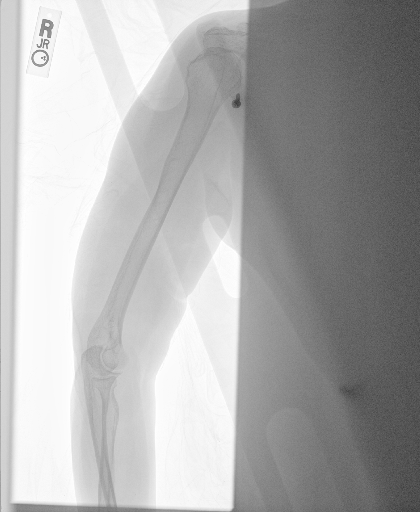

512 420
511 419 0 419 0 0 511 0
0 0 255 0
255


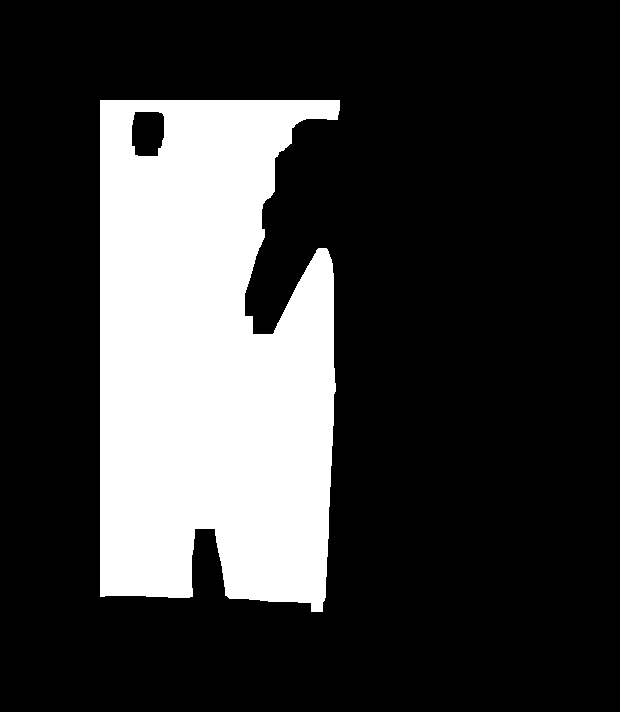

Found 2 contours.


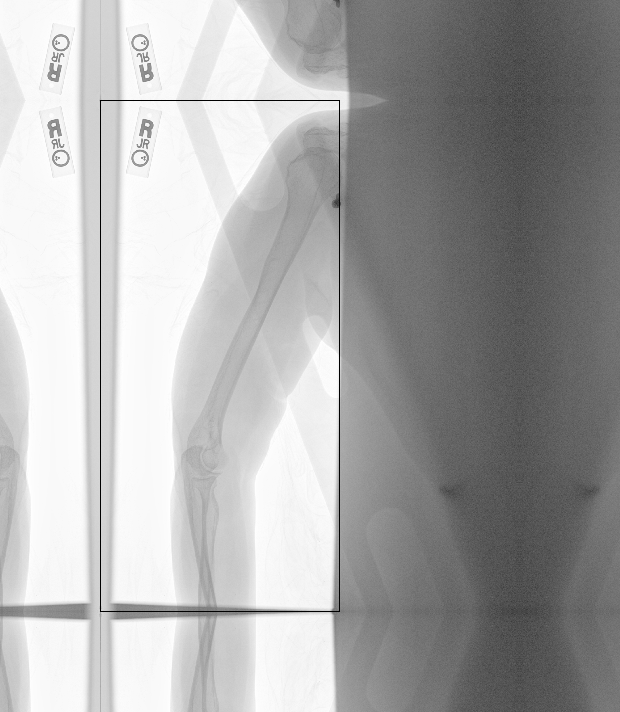

Image 1.png saved in /content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/XR_HUMERUS/valid/valid_negative/


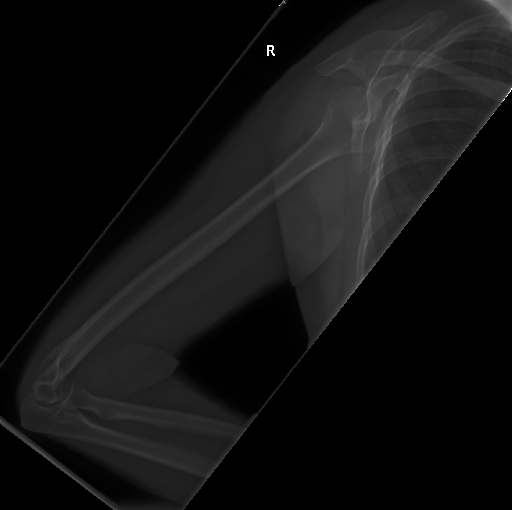

510 512
509 511 0 511 0 0 509 0
0 255 0 0
255


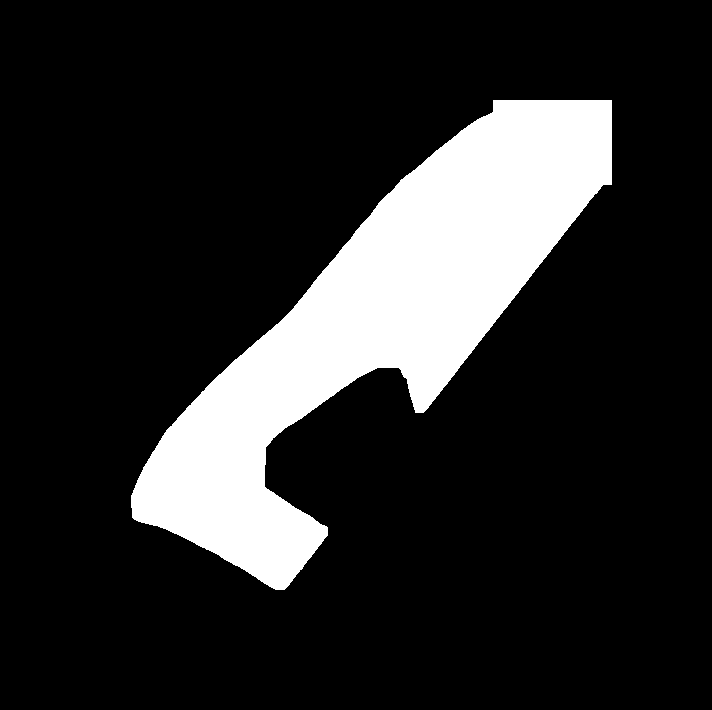

Found 1 contours.


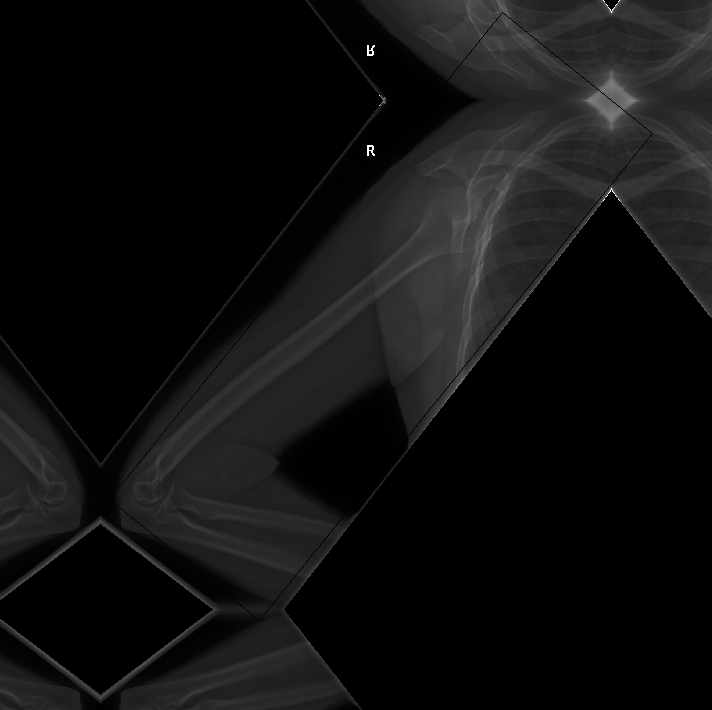

Image 2.png saved in /content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/XR_HUMERUS/valid/valid_negative/


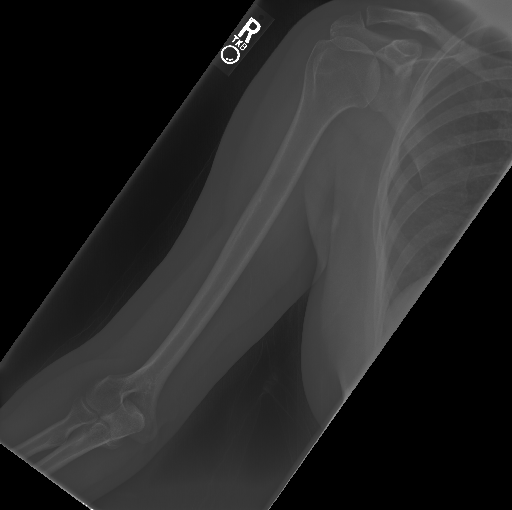

510 512
509 511 0 511 0 0 509 0
0 255 0 0
255


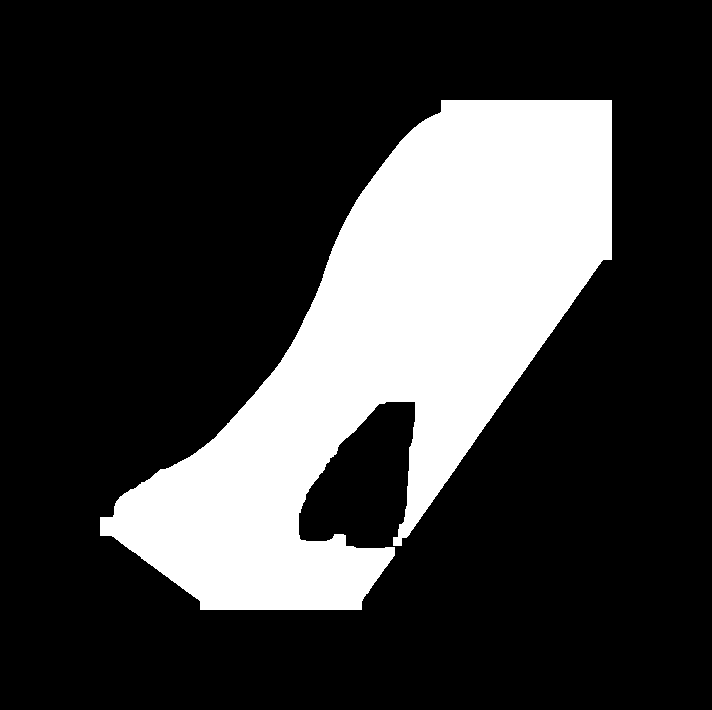

Found 1 contours.


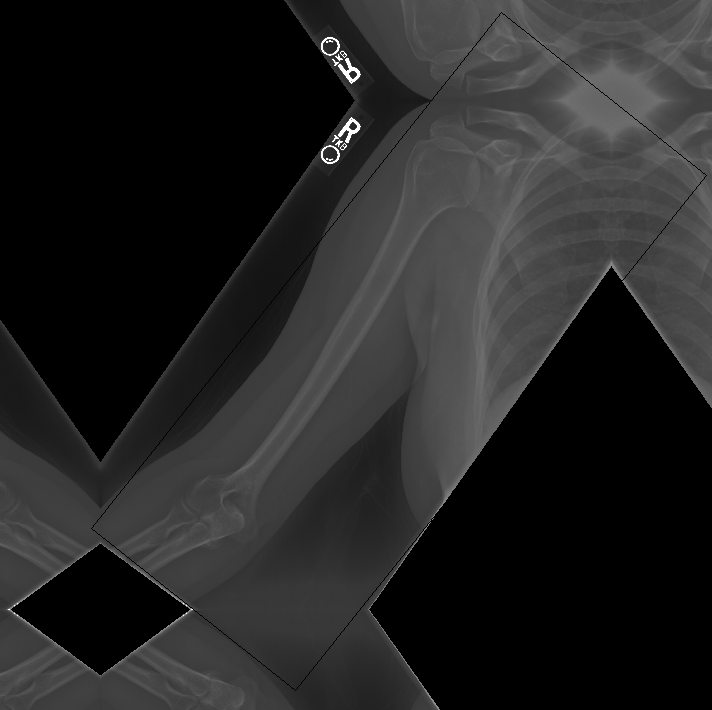

Image 3.png saved in /content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/XR_HUMERUS/valid/valid_negative/


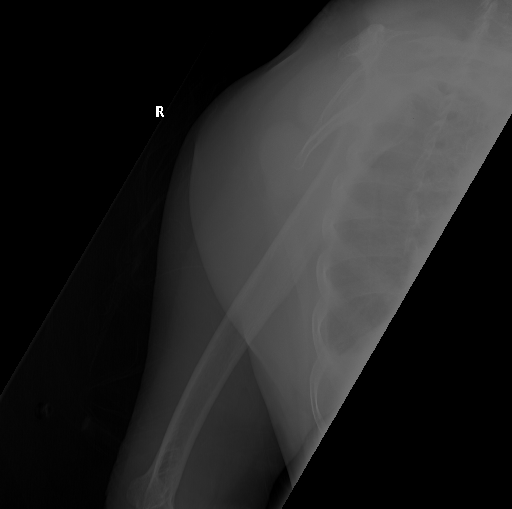

509 512
508 511 0 511 0 0 508 0
0 255 0 0
255


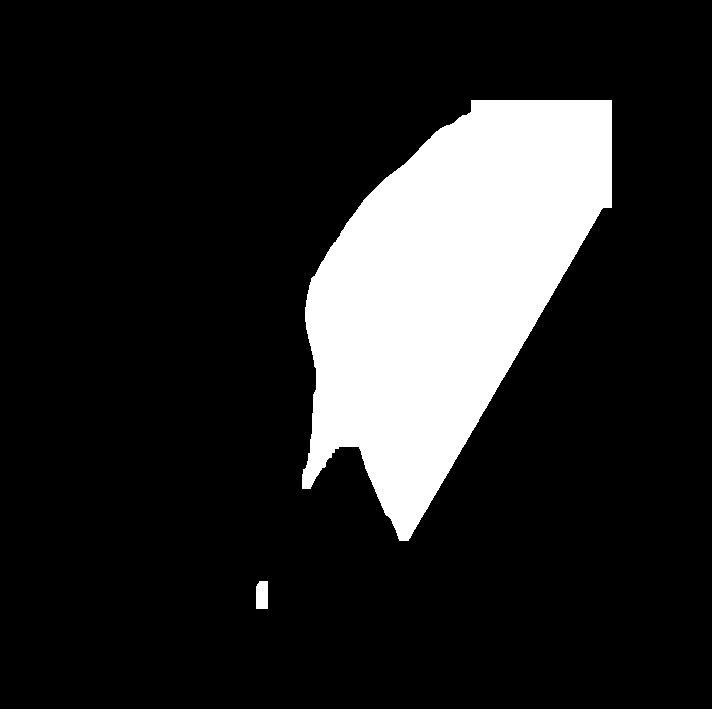

Found 2 contours.


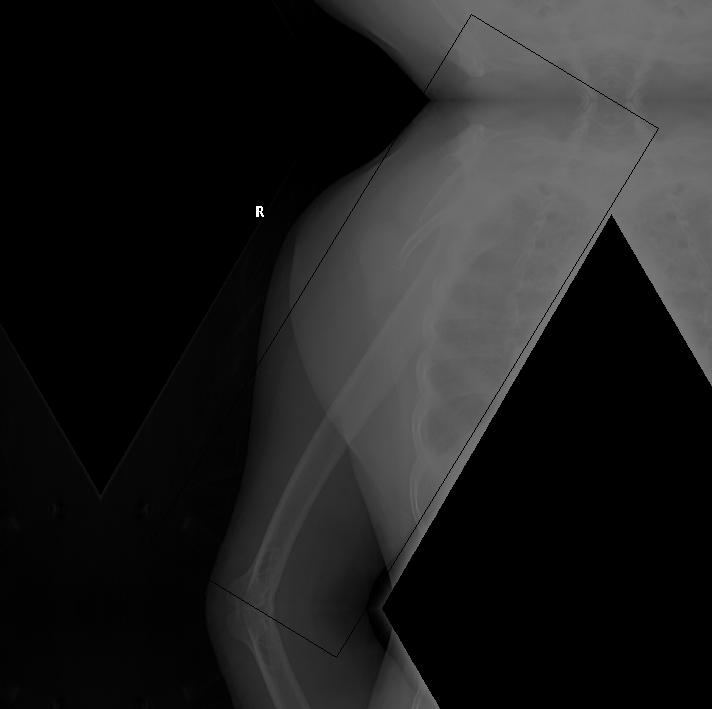

Image 4.png saved in /content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/XR_HUMERUS/valid/valid_negative/


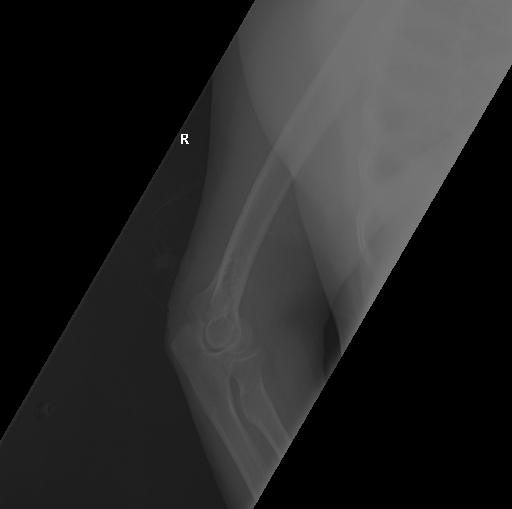

509 512
508 511 0 511 0 0 508 0
0 255 0 0
255


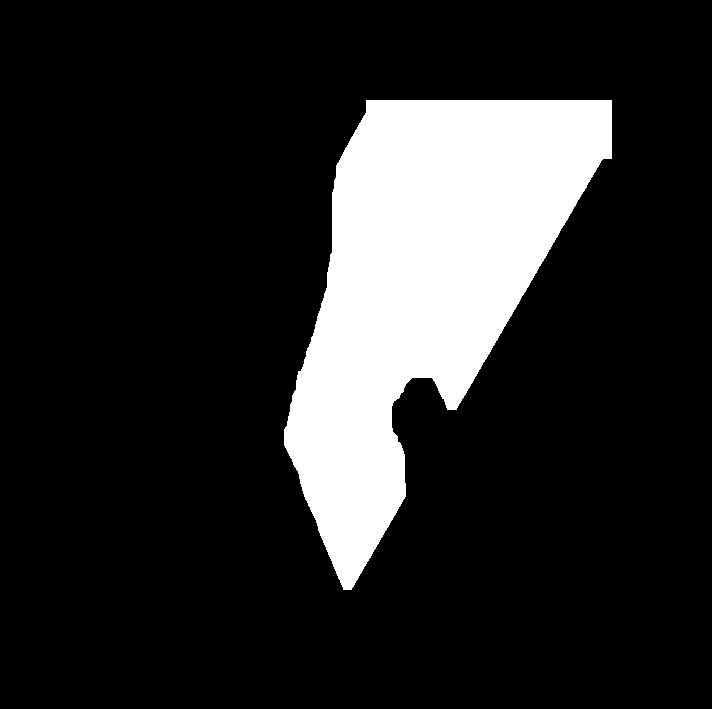

Found 1 contours.


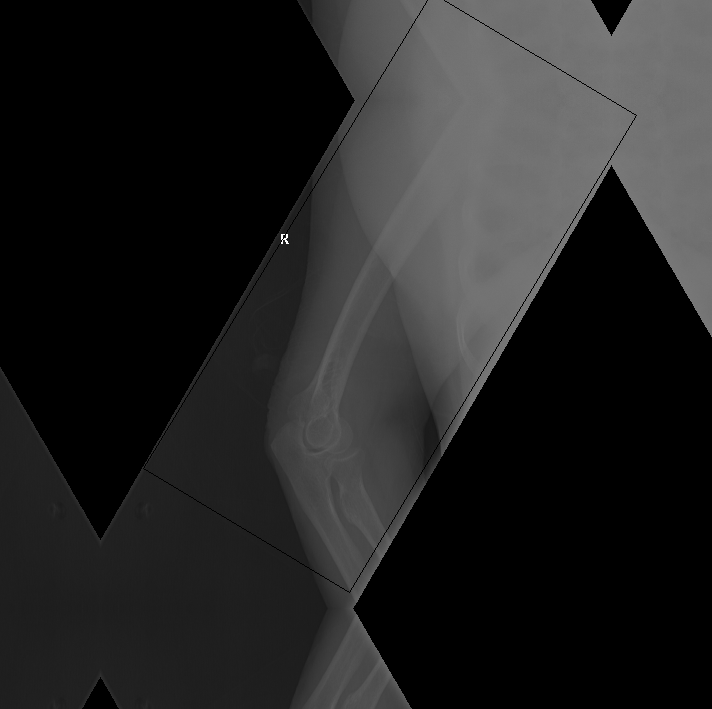

Image 5.png saved in /content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/XR_HUMERUS/valid/valid_negative/
Directory Already exists:  /content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/XR_HUMERUS/valid/valid_positive


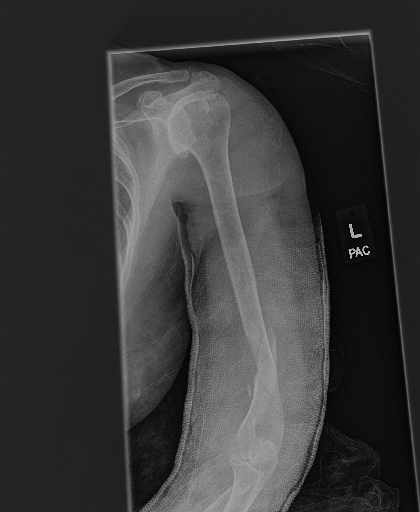

512 420
511 419 0 419 0 0 511 0
0 0 0 0
0


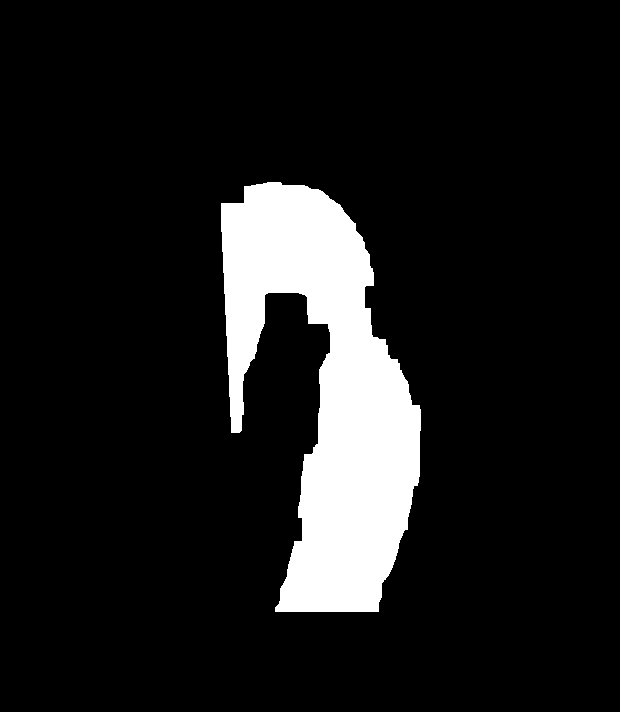

Found 1 contours.


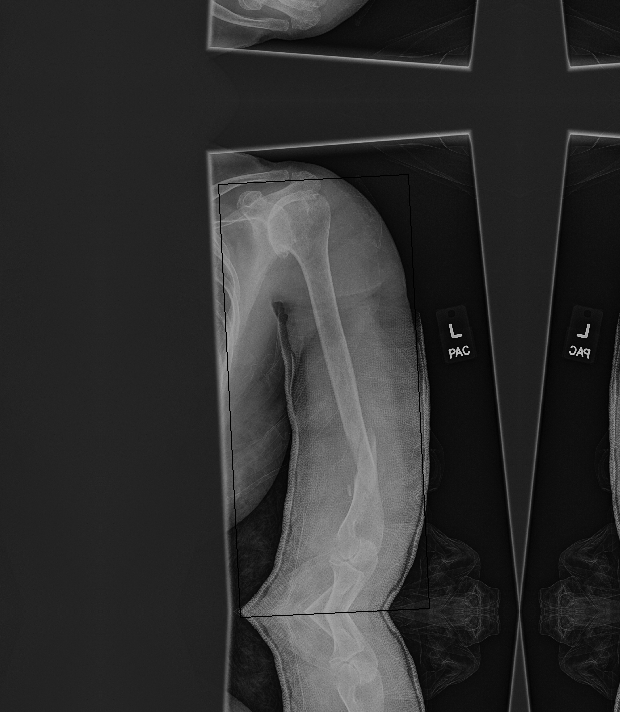

Image 0.png saved in /content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/XR_HUMERUS/valid/valid_positive/


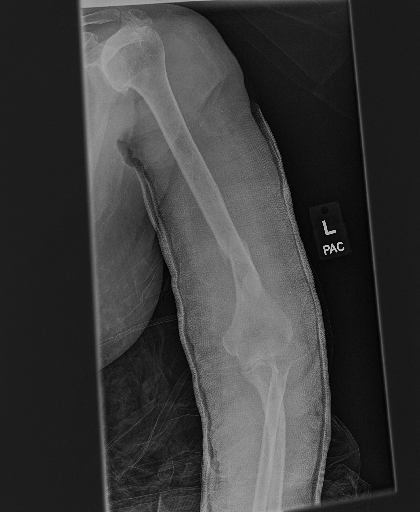

512 420
511 419 0 419 0 0 511 0
0 0 0 0
0


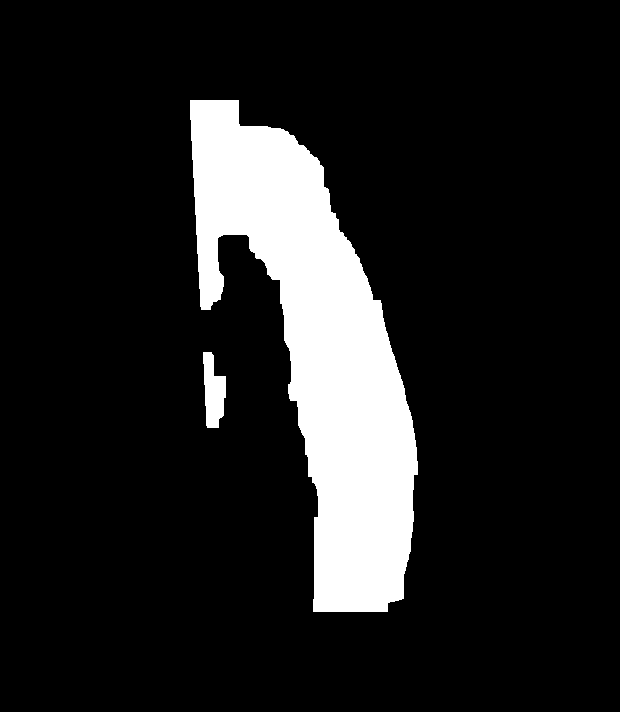

Found 2 contours.


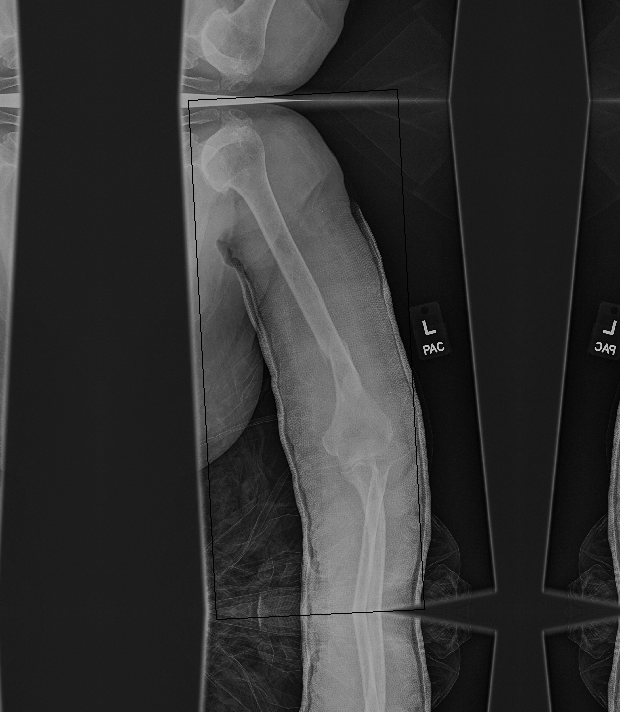

Image 1.png saved in /content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/XR_HUMERUS/valid/valid_positive/


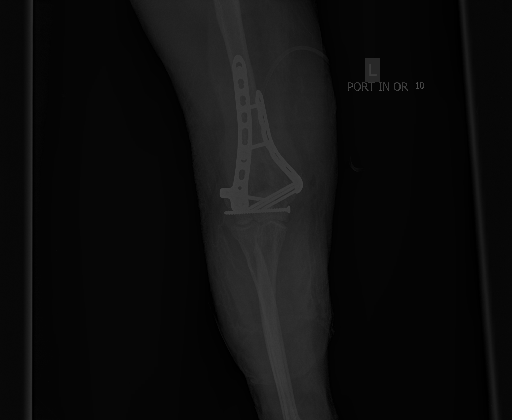

420 512
419 511 0 511 0 0 419 0
0 0 0 0
0


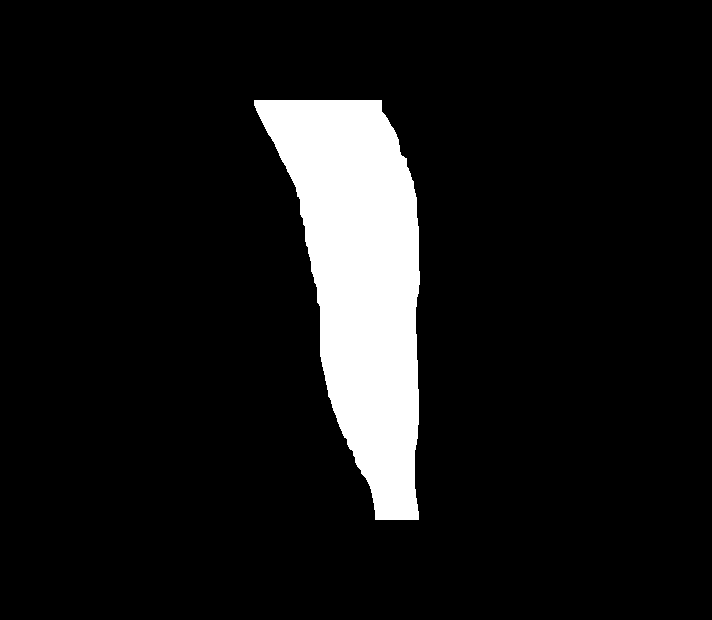

Found 1 contours.


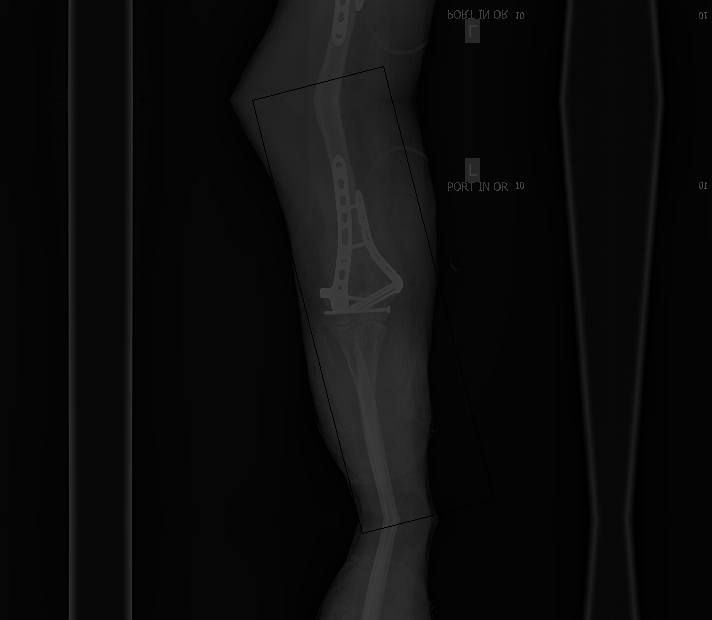

Image 2.png saved in /content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/XR_HUMERUS/valid/valid_positive/


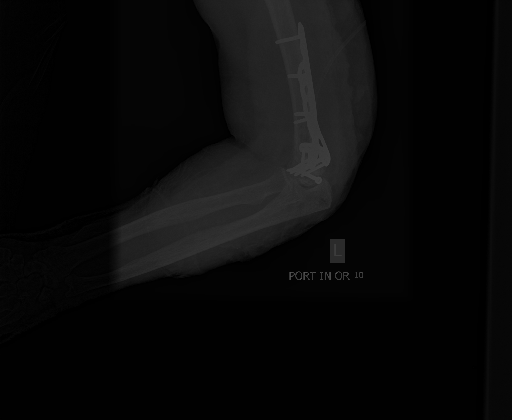

420 512
419 511 0 511 0 0 419 0
0 0 0 0
0


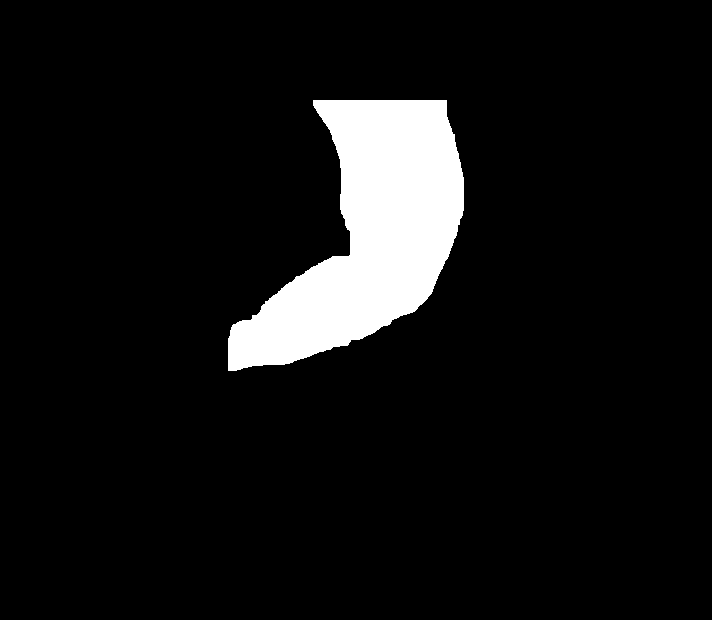

Found 1 contours.


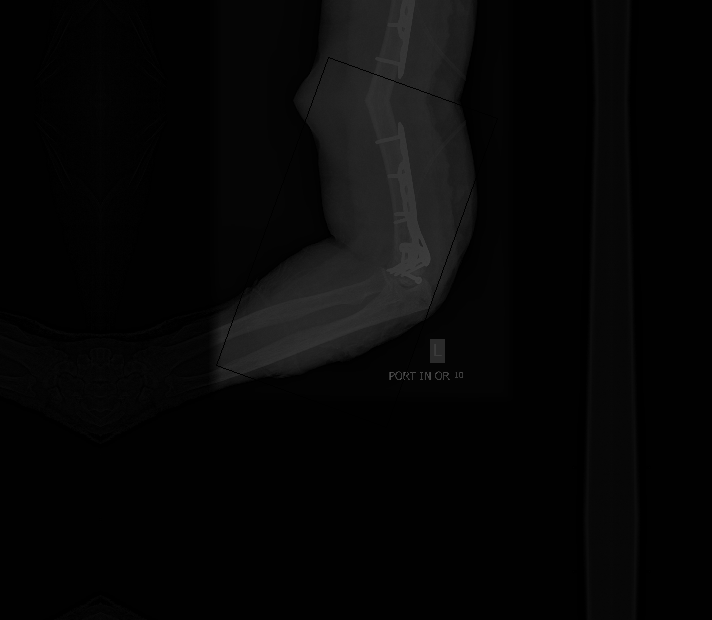

Image 3.png saved in /content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/XR_HUMERUS/valid/valid_positive/


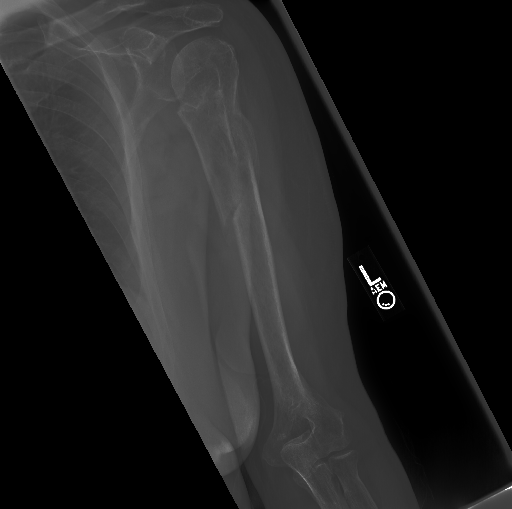

509 512
508 511 0 511 0 0 508 0
255 0 255 0
510


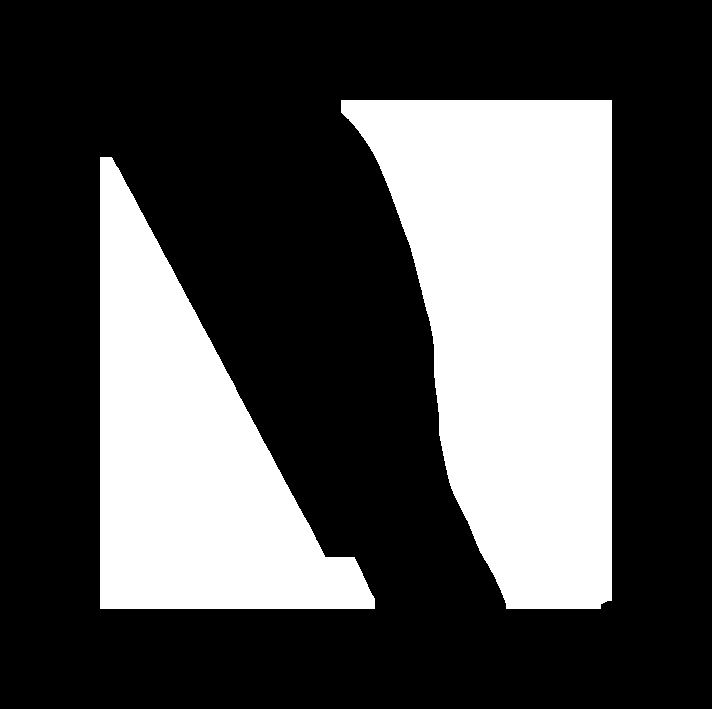

Found 2 contours.


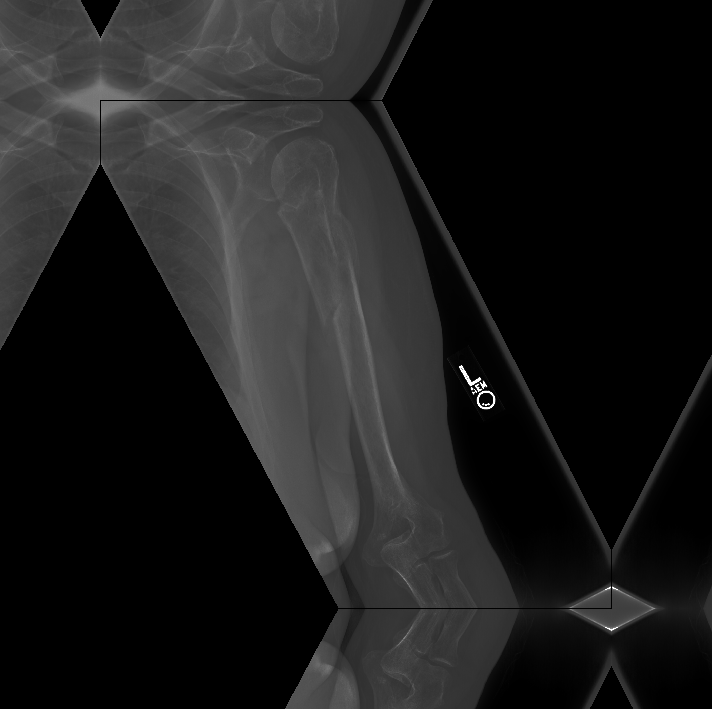

Image 4.png saved in /content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/XR_HUMERUS/valid/valid_positive/


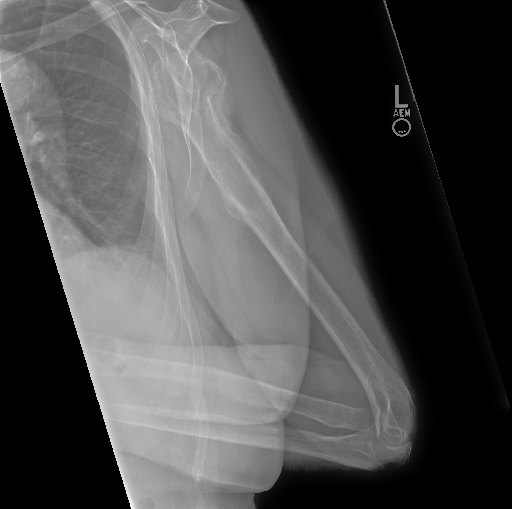

509 512
508 511 0 511 0 0 508 0
0 0 255 0
255


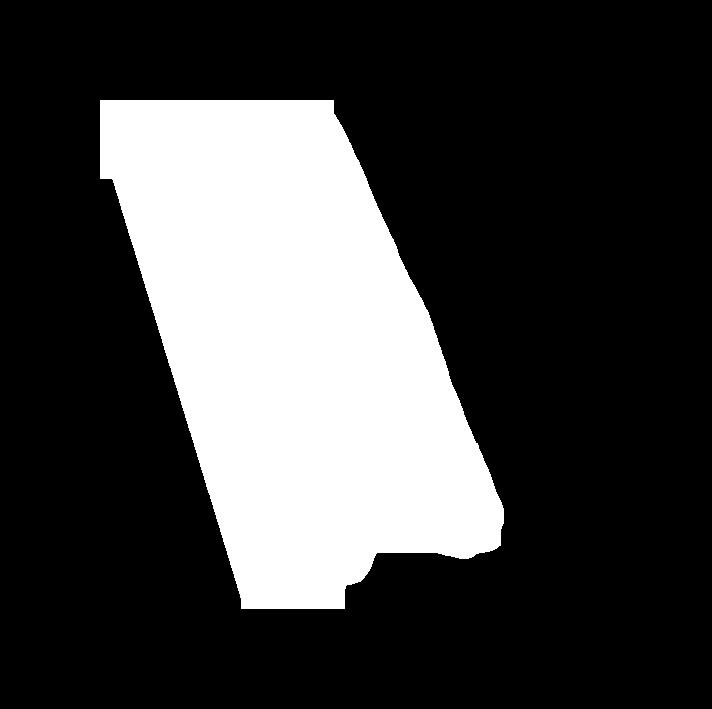

Found 1 contours.


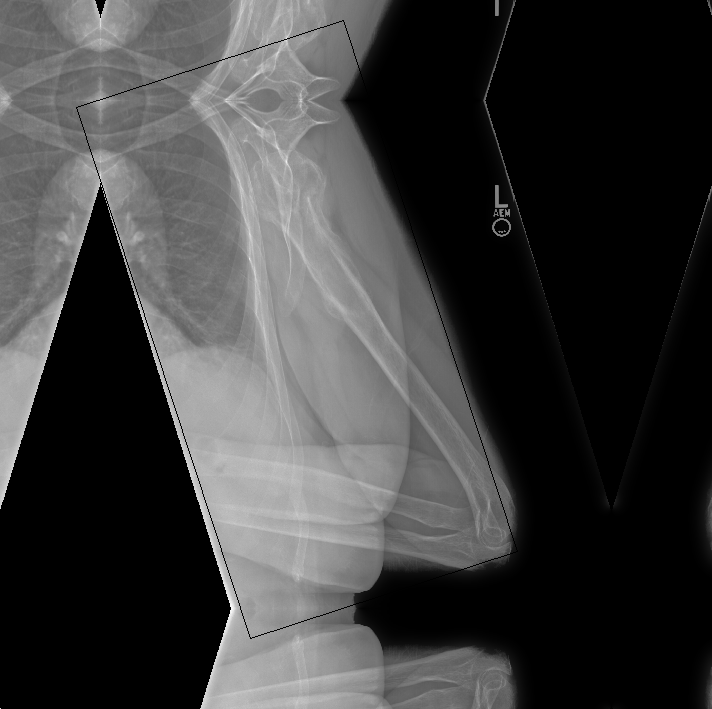

Image 5.png saved in /content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/XR_HUMERUS/valid/valid_positive/


In [63]:
trans = DataTransformation(PATH_ORIGIN, PATH_DESTINATION)

filters = ImageFilters()
trans.copy_imgs_apply_filters(5, filters.find_region_of_interest)


In [0]:
# #shape will give you [height, width, channel]
# h, w = img.shape[0:2]
# #get the bottom right pixel
# img = Otsu_thresh_after_gauss(image)
# img = 255 - img

# # TODO filtel images with inverted mask and revert them
# # find correctly contours
# # filter biggest correct contour and get its bounding box
#     # find center of bounding box and cut around it
#     # or
#     # cut as much of contour as possible and transform disproportionatedly

# bottom_right = img[h-1, w-1]
# bottom_left = img[0, w-1]
# upper_left = img[0, 0]
# upper_right = img[h-1, 0]

# def white_border(img):
#     h, w = img.shape[0:2]
#     for height in range(h):
#         img[height, 0] = 255
#         img[height, w-1] = 255
#     for width in range(w):
#         img[0, width] = 255
#         img[h-1, width] = 255
#     return img

# print(img)
# print(bottom_right,bottom_left,upper_left,upper_right)

# # img = dilate(img)
# # img = dilate(img)
# # img = dilate(img)
# trans.show_images(img)

# img = white_border(img)
# contours = find_contour(img)
# c = max(contours, key = cv2.contourArea)
# for c in contours:
# #     draw_contour(image, c)
#     x,y,w,h = cv2.boundingRect(c)
#     # draw the book contour (in green)
#     cv2.rectangle(image,(x,y),(x+w,y+h),(50,50,55),2)
#     trans.show_images(image)
# # print(contours)
# # draw_contour(image, c)    
